# A/B-тестирование

# Описание проекта:

Наша задача — провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оценить корректность проведения теста
- Проанализировать результаты теста

Чтобы оценить корректность проведения теста, проверим:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

# Техническое задание:

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

# Описание данных:

**Для анализа данных нам предоставлены 4 дадасета:**

1. `"/datasets/ab_project_marketing_events.csv"` - календарь маркетинговых событий на 2020 год.
2. `"/datasets/final_ab_new_users.csv"` -  пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года
3. `"/datasets/final_ab_new_events.csv"` - действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
4. `"/datasets/final_ab_participants.csv"` - таблица участников тестов

# Рассмотрим структуры данных каждого файла:

1. `"ab_project_marketing_events.csv"` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

2. `"final_ab_new_users.csv"` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

3. `"final_ab_events.csv"` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

4. `"final_ab_participants.csv"` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

# План исследования:

1. **Исследуем данные:**

- Требуется ли преобразование типов?
- Опишим природу пропущенных значений и дубликатов, если их обнаружим.**

2. **Оценим корректность проведения теста. Обратим внимание на:**

- Соответствие данных требованиям технического задания. Проверим корректность всех пунктов технического задания.
- Время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями.
- Аудиторию теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.

3. **Прооведём исследовательский анализ данных:**
   
- Количество событий на пользователя одинаково распределены в выборках?
- Как число событий в выборках распределено по дням?
- Как меняется конверсия в воронке в выборках на разных этапах?
- Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

4. **Оценим результаты A/B-тестирования:**

- Что можно сказать про результаты A/В-тестирования?
- Проверим статистическую разницу долей z-критерием.

5. **Опишим выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделаем общее заключение о корректности проведения теста:**

## Загрузим данные и подготовим их к анализу:

### Импортируем библиотеки для работы:

In [66]:
# импортируем библиотеки
import pandas as pd
import math as mth
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import scipy.stats as stats
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# При использованиии некоторых атрибутов могут показываться предупреждения, чтобы такого не было, уберём их
import warnings
warnings.filterwarnings('ignore')

In [67]:
# Загрузим данные из тестов в переменные
# Календарь маркетинговых событий на 2020 год
try:ab_project_marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
except:ab_project_marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
# Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.  
try:final_ab_new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
except:final_ab_new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
# Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года. 
try:final_ab_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
except:final_ab_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
# Таблица участников тестов.  
try:final_ab_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
except:final_ab_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

### Выводим информацию данных датасетов на экран:

In [68]:
# Покажем календарь маркетинговых событий 2020 года
display(ab_project_marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [69]:
# посмотрим на инофрмацию
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


Видим, что даты указаны, как тип `object`, в дальнейшем предоработаем, переведём в `to_datetime` если будет необходимо.

In [70]:
# посмотрим на пользователей,зарегистрировавшихся с 7 по 21 декабря 2020 года. 
display(final_ab_new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [71]:
# посмотрим на информацию
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


Так же указана дата регистрации, как тип `object`, в дальнейшем предоработаем, переведём в `to_datetime` если будет необходимо.

In [72]:
# действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.  
display(final_ab_events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


Видим, что есть пропуски, в дальнейшем предоработаем их,посмотрим более детально.

In [73]:
# посмотрим на информацию
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


Дату и время покупки указана, как `object` необходимо поменять на `to_datetime`

In [74]:
# таблица участников теста
display(final_ab_participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


In [75]:
# посмотрим на информацию
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


**Вывод:** 
Данные открываются корректно. Есть пропуски, посмотрим на них детально на следующем этапе и предоработаем. Так же необходимо изменить тип данных `object` на `to_datetime` где это необходимо.

### Выполним предоработку данных:

#### Предоработаем и проверим данные на дубликаты:

In [76]:
# Календарь маркетинговых событий на 2020 год
print('Наличие дубликатов:' ,ab_project_marketing_events.duplicated().sum())

Наличие дубликатов: 0


In [77]:
# Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года
print('Наличие дубликатов:', final_ab_new_users.duplicated().sum())

Наличие дубликатов: 0


In [78]:
# Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
print('Наличие дубликатов:', final_ab_events.duplicated().sum())

Наличие дубликатов: 0


In [79]:
# Таблица участников тестов
print('Наличие дубликатов:', final_ab_participants.duplicated().sum())

Наличие дубликатов: 0


Проверили на наличие дубликатов, дубликатов нет.

#### Предоработаем и проверим данные на пропуски:

In [80]:
# Календарь маркетинговых событий на 2020 год
print('Наличие пропусков:' ,ab_project_marketing_events.isna().sum())

Наличие пропусков: name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


In [81]:
# Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года
print('Наличие пропусков:', final_ab_new_users.isna().sum())

Наличие пропусков: user_id       0
first_date    0
region        0
device        0
dtype: int64


In [82]:
# Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
print('Наличие пропусков:', final_ab_events.isna().sum())

Наличие пропусков: user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


Обнаружили пропуски в колонке `details` их количество составляет 377577.

Посмотрим, что  с ними можно сделать.

In [83]:
# выведем последние 10 строк, покажем пропуски
display(final_ab_events.tail())

,user_id,event_dt,event_name,details
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN
440316,7AEC61159B672CC5,2020-12-30 11:36:13,login,NaN


In [84]:
# посмотрим на уникальные значения этой колонки 
# дополнительные данные о событии.# Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах. 
final_ab_events['details'].value_counts()

4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64

In [85]:
# Посмотрим на события, которые есть  в данных
final_ab_events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

In [86]:
# Посмотрим как события purchase пересекаются с details, и узнаем есть  ли пропуски
print('Пропуски при событии purchase с details: %d ' % round(final_ab_events[final_ab_events['event_name'] == 'purchase']['details'].isna().mean()))
# Посмотрим остальные пересечение событий с details, кроме purchase и узнаем есть  ли пропуски 
print('Пропуски при исключениии purchase: %d' % round(final_ab_events[~(final_ab_events['event_name'] == 'purchase')]['details'].isna().mean()))

Пропуски при событии purchase с details: 0 
Пропуски при исключениии purchase: 1


In [87]:
# Проверим, убрались ли пропуски
print('Наличие пропусков:', final_ab_events.isna().sum())

Наличие пропусков: user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


Пропуски обработали, теперь  пропусков нет.

In [88]:
# Таблица участников тестов
print('Наличие пропусков:', final_ab_participants.isna().sum())

Наличие пропусков: user_id    0
group      0
ab_test    0
dtype: int64


**Вывод:** Обработали пропуски во всех датасетах. В `final_ab_events['details']`, заменили пропущенные значения, логически обосновали и подтвердили, что пересечения c событиями `purchase` нет, поставили заглушки `-1`,так как отрицательной цены не наблюдается в колонке.

#### Изменим тип данных, где это необходимо.

In [89]:
# Покажем календарь маркетинговых событий 2020 года
display(ab_project_marketing_events.head(1))
# Изменим тип данных дату начала компании
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
# Изменим тип данных дату завершения компании
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])
# Проверим, что получилось
ab_project_marketing_events.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [90]:
# посмотрим на пользователей,зарегистрировавшихся с 7 по 21 декабря 2020 года. 
display(final_ab_new_users.head(1))
# дату регистрации изменим тип данных
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])
# посмотрим, что  получилось
final_ab_new_users.info()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [91]:
# действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.  
display(final_ab_events.head(1))
# изменим тип данных, дату и время покупки 
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])
# проверим результат
final_ab_events.info()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


**Вывод:** 
1. Произвели проверку дубликатов, дубликатов не было обнаружено
2. Произвели проверку пропусков, обнаружили пропуски в колонке `final_ab_events['details']`, провеирили пересечение с purchase, выяснили, что его нет, поставили заглушки `-1`,так как отрицательной цены не наблюдается в колонке.Остальных пропусков не было обнаружено.
3. Произвели замену типа данных с `object` на `to_datetime` в сетах :
- ab_project_marketing_events колонки `['start_dt']` 
- ab_project_marketing_events колонки `['finish_dt']`

- final_ab_new_users колонки `['first_date']`
- final_ab_events колонки `['event_dt']`

## Оценим корректность проведения теста. Обратим внимание на:

### Соответствие данных требованиям технического задания. Проверим корректность всех пунктов технического задания.

#### Название теста: recommender_system_test;

Посмотрим не пересекаются ли пользователи из двух групп в тестах

In [92]:
# Посмотрим на общее количество пользщователей 
final_ab_participants['user_id'].count()

18268

In [93]:
# найдём пользывателей в каждой группе 
# rs_test - recommender_system_test (rs_test)
# ieu_test - interface_eu_test (ieu_test) 
rs_test = final_ab_participants[final_ab_participants['ab_test'] == 'recommender_system_test']
ieu_test = final_ab_participants[final_ab_participants['ab_test'] == 'interface_eu_test']

In [94]:
# Определим общее количество пользователей в двух группах пользователей    
all_user = set(rs_test['user_id']).difference(ieu_test['user_id'])
print('Общее количество пользователей:',len(all_user))
# Определим количество пользователей, которые пересекаются в группах
intersection_user = np.intersect1d(rs_test['user_id'], ieu_test['user_id'] )
print('Количество пересекающихся пользователей:',intersection_user.shape[0])

Общее количество пользователей: 5099
Количество пересекающихся пользователей: 1602


In [95]:
# Удалим данных пользователей из таблицы:
final_ab_participants = final_ab_participants[~final_ab_participants['user_id'].isin(intersection_user)]

In [96]:
# готовый тест с пользователями для работы
rs_test = final_ab_participants[final_ab_participants['ab_test'] == 'recommender_system_test']
# выведем на экран
display(rs_test.head(5))

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test


После удаления пересекающихся пользователей, мы получили чистые данные таблицы rs_test - recommender_system_test 

In [97]:
# посмотрим на количество пользователей  в группе после очистки от пересечения 
print('Колиичество пользователей после очистки:',rs_test['user_id'].nunique())

Колиичество пользователей после очистки: 5099


Количество участников теста составило 5099 человек. По техническому заданию у нас должно быть 6000 человек, есть несоответсвие.Которое нужно будет обсудить с отделом. Учитывая такую  разницу, результаты теста могут могут повлиять на результат.

Проверим в разбивке на группы по количеству пользователей 

In [98]:
print('Пользователи группы A:', rs_test['user_id'][rs_test['group'] == 'A'].count())
print('Пользователи группы B:', rs_test['user_id'][rs_test['group'] == 'B'].count())

Пользователи группы A: 2903
Пользователи группы B: 2196


Пользователей группы 'A' больше пользователей группы 'B', распределение неравномерное, может повлиять на результаты теста.

#### Найдём пользователей, пренадлежащих к EU региону 

In [99]:
# Возьмём участников нашего теста rs_test, объединим их с участниками final_ab_new_users
# таким образом узнаем какие вообще регионы учавствуют в тесте
rs_test_region = rs_test.merge(final_ab_new_users, how = 'left', on = 'user_id')
# выведем на экран
rs_test_region.head(5)

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
3,4FF2998A348C484F,A,recommender_system_test,2020-12-20,EU,Mac
4,7473E0943673C09E,A,recommender_system_test,2020-12-16,EU,iPhone


In [100]:
# отразим пользователей на графике из разных регионов
region_user = rs_test_region.groupby('region')['user_id'].agg({'count'}).sort_values(by='count', ascending=False).reset_index()
# выведем на экран
display(region_user)

,region,count
0,EU,4749
1,N.America,223
2,APAC,72
3,CIS,55


In [101]:
# Отразим на графике
fig = px.bar(region_user, 
       # по оси x выберем регион
       x ='region', 
       # по оси y количество пользователей
       y = 'count',
       # обозначим регион      
       text = 'count',
       # выберем цвет     
       color = 'region',
       # сделаем подписи на графике      
       title = 'Количество пользователей по регионам',
      labels = {'count' : 'Количество пользователей',
               'region' : 'Регион'})

fig.show()

Количество пользователей по регионам:
- EU	4749
- N.America	223
- APAC	72
- CIS	55

Большее место занимают пользователи из EU (Европейского союза), учитывая что пользователи присутсвуют из разных  регионов, это тоже может повлиять на результат.

#### Найдём процент пользователей из региона EU для тестируемых пользователей, относительно общих пользователей из EU

In [102]:
# рассчитаем сколько  всего пользователей зарегистрировались с 7 по 21 декабря
# сделаем срез по данной дате сделаем дату с 7 по 12
new_eu_user = final_ab_new_users.query('first_date <= "2020-12-21"')
# теперь отфильтруем пользователей из Европы по нашему срезу 
new_eu_act = new_eu_user[new_eu_user['region'] == 'EU']['user_id'].nunique()
print('Общее количество новых пользователей из региона Европа составило:', new_eu_act)

Общее количество новых пользователей из региона Европа составило: 42340


In [103]:
# Расчитаем новых пользователей региона EU попавших в тест
# объединим таблицы с новыми пользователями и тестируемыми пользователя  
new_eu_user_test = final_ab_new_users.merge(rs_test[rs_test['ab_test'] == 'recommender_system_test'],
                                    how="inner",
                                    on='user_id')
# рассчитаем процент тестируемых пользователей для региона Европа 
print('Процент тестируемых пользователей из региона Европа: {:.2%}'. format(new_eu_user_test['user_id'].nunique()/
                                                                    (new_eu_act)))

Процент тестируемых пользователей из региона Европа: 12.04%


Процент пользователей EU по техническому заданию  должен быть 15 % , у нас получается 12.04 %, так же имеем несоответствие, что может повлиять на результаты теста

#### Отредактируем события, что больше 14 дней как написано в техническом задании, с момента регитрации пользователя

In [104]:
# Соединим наши отфильтрованную таблицу с таблицей  действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
final_rs_test = rs_test_region.merge(final_ab_events, how ='left', on = 'user_id')
# Проверим
display(final_rs_test.head(3))

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN


In [105]:
# Уберём события, которые не соответсвтуют условию
# создадим столбец с жизнью пользователей и отредактируем 
final_rs_test['lifetime'] = final_rs_test['event_dt'] - final_rs_test['first_date']
final_rs_test = final_rs_test[final_rs_test['lifetime'] <= '14 days']
# выведем на экан, посмотрим,что получилось
display(final_rs_test.head(5))

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,lifetime
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,0 days 14:43:27
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,0 days 14:43:29
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,0 days 14:43:27
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN,0 days 14:43:27
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN,0 days 15:46:06


In [106]:
# Найдём окончательное число участников теста
final_rs_test['user_id'].nunique()

2788

Из 5000 пользователей у нас осталось 2788 человек. Это  может значительно повлиять на  результаты теста.

Посмотрим на распределение пользователей по группам после финальной фильтрации.

In [107]:
print('Пользователи группы A:', final_rs_test['user_id'][final_rs_test['group'] == 'A'].nunique())
print('Пользователи группы B:', final_rs_test['user_id'][final_rs_test['group'] == 'B'].nunique())

Пользователи группы A: 2082
Пользователи группы B: 706


Разбиение пользователей неравномерное, пользователей группы А больше пользователей группы Б:

Пользователи группы А: 2082

Пользователи группы Б: 706

Что можем значительно повлиять на результат, проверим.

#### Посмотрим на интервал, в котором происходили события для тестируемых пользователей.

In [108]:
# Выведем на экран
print('Начало события:',final_rs_test['event_dt'].min())
# Выведем на экран
print('Конец события:', final_rs_test['event_dt'].max())                                                                               

Начало события: 2020-12-07 00:16:00
Конец события: 2020-12-29 23:38:29


In [109]:
# проверим пересечение ивентов, чем был связан рост пользователей в группе А относительно группы Б 
events_crosses = ab_project_marketing_events[(ab_project_marketing_events['start_dt'] > '2020-12-07') &
                            (ab_project_marketing_events['start_dt'] < '2021-01-04')]
display(events_crosses)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Здесь есть  несоответствие с техническим заданием, начало теста с 2020-12-07 и завершение теста 2020-01-04. Также этот интервал пересекается с датой проведения маркетингового события Christmas&New Year Promo,что мы видим из таблицы, что так же скажется на результатах теста.

#### Посмотрим на дату набора пользователей, которая должна соотвествовать интервалу с 2020-12-07 по 2020-12-21.

In [110]:
print('Начало регистрации:', rs_test_region['first_date'].min())
print('Конец регистрации:', rs_test_region['first_date'].max())

Начало регистрации: 2020-12-07 00:00:00
Конец регистрации: 2020-12-21 00:00:00


Регистрация пользователей произошла с 2020-12-07 по 2020-12-21.

даты регистрации соответствуют техническому заданию.

**Вывод:** Мы рассмотрели соответствие техничекому заданию или нет:

Рассматриваем `recommender_system_test`:

- Посмотрим на дату набора пользователей и дату остановки набора (с 2020-12-07 по 2020-12-21) (Соответствует)
- Посмотрим на интервал, в котором происходили события для тестируемых пользователей (с 2020-12-07 по 2020-12-29), по техническому заданию дата остановки: 2021-01-04:
- тестируемые пользователи совершали действия в интервале с 2020-12-07 00:16:00 по 2020-12-29 23:38:29;
- данное пересечение происходит с Christmas&New Year Promo.

Аудитория: 15% новых пользователей из региона EU:
Среди тестируемых есть и другие регионы:

- EU - 4749 
- N.America 223
- APAC 72
- CIS 55
- Процент тестируемых пользователей EU относительно общих пользователей EU составил: 12.04%.(по условию ,должно быть 15%). Есть  несоответствие,но нужно учитывать, что мы смотрим уже отфильтрованных  пользователей,по этому такой результат вполне может быть.


- Ожидаемое количество участников теста: 6000:
- Изначально, количество пользователей recommender_system_test сосатвило 6701 человек. Но мы проверили пересекающихся пользователей,которые  есть в обоих группах ,количество 1602 , и отфильтровали данных пользователей на этом этапе, в связи с этим после очистки количество пользователей стало 5099, распределили их по группам:


- группе А - 2903 пользователя 
- группе В - 2196 пользователей

Выборка между группами неравномерная , в группе А пользователей больше. 

Дальше отфильтровали по условию и количество пользователей сократилось почти  2 раза, это  свидетельствует о том, что  результаты теста могут быть искажены.Количество пользователей составило 2788 человек.

По поводу несоответсвия пользователей мы уточним у людей, которые предоставляли нам данные, а сами перейдём к следующему этапу проверки.

## Проведём исследовательский анализ данных:

### Количество событий на пользователя одинаково распределены в выборках?

In [111]:
# сгруппируем пользователей по количеству событий, посмотрим событие для каждого пользователя 
final_count_event = final_rs_test.groupby('user_id').agg(count = ('event_name', 'count')).reset_index()
# объединим с нашей финальной таблицей тестируемых, выберем только  нужные столбцы
final_count_event = final_count_event.merge(final_rs_test, how = 'left', on = 'user_id')[['user_id', 'count', 'group']]
# выводим на экран
display(final_count_event)

,user_id,count,group
0,0010A1C096941592,12,A
1,0010A1C096941592,12,A
2,0010A1C096941592,12,A
3,0010A1C096941592,12,A
4,0010A1C096941592,12,A
...,...,...,...
18149,FFAE9489C76F352B,6,A
18150,FFAE9489C76F352B,6,A
18151,FFAE9489C76F352B,6,A
18152,FFAE9489C76F352B,6,A


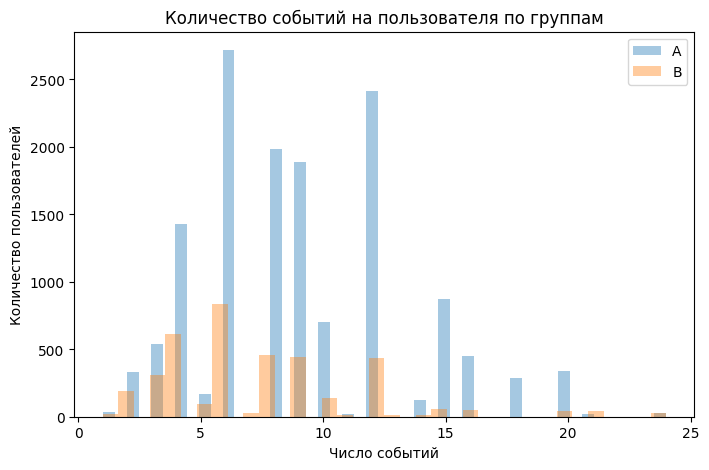

In [112]:
# Визуализируем на графике 
plt.figure(figsize=(8,5))
# сделаем подпись названия  
plt.title('Количество событий на пользователя по группам')
# выведем группу А, покажем kde = False 
sns.distplot(final_count_event[final_count_event['group'] == 'A']['count'], label='A',kde =False)
# выведем группу B, покажем kde = False 
sns.distplot(final_count_event[final_count_event['group'] == 'B']['count'], label='B',kde = False)
# подпишем ось Y
# уберём легенду
plt.legend()

plt.ylabel('Количество пользователей')
# подпишем ось X 
plt.xlabel('Число событий')
# выведем на экран
plt.show()

In [113]:
# покажем среднее количество в группе А  
print('Среднее количество событий в группе А :', round(final_count_event[final_count_event['group'] == 'A']['count'].mean(), 2))
# покажем среднее количество событий в группе Б
print('Среднее количество событий в группе B :', round(final_count_event[final_count_event['group'] == 'B']['count'].mean(), 2))

Среднее количество событий в группе А : 9.01
Среднее количество событий в группе B : 7.36


Число событий на 1 пользователя выше в группе А. 

#### Рассмотрим распределение событий в логе по количеству:

In [114]:
# сгруппируем события по количеству,отсортируем в порядке убывания  
count_event = final_rs_test.groupby('event_name').agg(count=('user_id', 'count')).sort_values(by = 'count', ascending = False).reset_index()
# выведем на экран
display(count_event)

,event_name,count
0,login,8194
1,product_page,5108
2,product_cart,2446
3,purchase,2406


In [115]:
# нарисуем график
fig = px.bar(count_event,
       # обозначим ось X      
       x ='event_name',
       # обозначим ось Y      
       y = 'count',
       # покажем число  событий     
       text = 'count',
       # обозначим цвет количества      
       color = 'count',
       # сделаем подписи      
       title = 'События по частоте',  
      labels = {'count' : 'Число событий',
               'event_name' : 'Названия события'})
fig.show()

- Самое частое событие является login (8194) 
- далее пользователь переходит на страницу продукта product_page (5108)
- далее   он попадает в продуктовую корзину product_cart (2446)
- далее переходит к покупке purchase (2406)

Мы видим что конверсия, в продуктовой корзине почти такая же как и конверсия покупки, вероятно можно совершить покупку напрямую не переходя в корзину с товаром.

#### Посчитаем какое количество пользователей совершали каждое из этих событий.

In [116]:
# сгруппируем события по количеству пользователей, рассматриваем уникальных пользователей
uid_event = final_rs_test.groupby('event_name').agg(count = ('user_id','nunique')).sort_values(by = 'count',ascending = False).reset_index()
# выводим на экран                                                                                                                                                               
display(uid_event)

,event_name,count
0,login,2787
1,product_page,1757
2,purchase,850
3,product_cart,826


Видим, что пользователей больше совершало события покупка, а должны были сперва переходить в корзину

In [117]:
# найдём проценты события, которые совершили пользователи 
# отфильтрованных пользователей поделим на общее число пользователей 
uid_event['percent'] = round((uid_event['count'] / rs_test['user_id'].nunique()) * 100, 2)
# выберем необходимые нам столбцы
uid_event.columns = ['event_name', 'count', 'percent']
# выведем на экран 
display(uid_event)

,event_name,count,percent
0,login,2787,54.66
1,product_page,1757,34.46
2,purchase,850,16.67
3,product_cart,826,16.20


В процентном соотношении мы видим, что число пользователей, совершившие покупку больше чем число  пользователей, которые зашли в корзину.

In [118]:
# визуализируем наш результат
fig = px.bar(uid_event,
       # события по оси X       
       x ='event_name',
       # количество по оси Y     
       y = 'count',
       # покажем проценты на событиях      
       text = 'percent', 
       # распределим количество по цветам      
       color = 'count',     
       # сделаем обозначения и подписи      
       title = 'Количество уникальных пользователей по событиям',
      labels = {'count' : 'Количество',
               'event_name' : 'События '})
fig.show()

Мы видим как пользователи совершали события:
- Login - 2787 (54.66%)
- Product Page - 1757 (34.46%)
- Purchase - 850 (16.67%)
- Product Cart - 826 (16.2%)

Стандартный порядок выглядит не много иначе, сначала пользователь заходит в корзину, потом уже переходит на экран с покупкой.
Следовательно, пользователи покупают не заходя в корзину. Сообщим об этом.

### Посмотрим распределение событий по дням

In [119]:
# переведем время события в формат даты для того,чтобы узнать дни посчитаем количество событий на каждую из дат по группам
final_rs_test['event_dt'] = final_rs_test['event_dt'].dt.date
# посчитаем количество событий на каждую из дат по группам
final_event_rs = final_rs_test.groupby(['event_dt', 'group']).agg(developments = ('event_name', 'count')).reset_index()
final_event_rs.head()

,event_dt,group,developments
0,2020-12-07,A,234
1,2020-12-07,B,290
2,2020-12-08,A,267
3,2020-12-08,B,183
4,2020-12-09,A,296


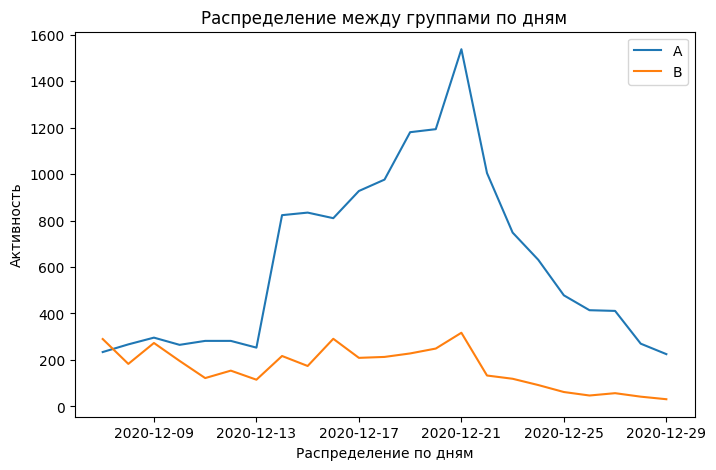

In [120]:
# Построим линейные графики 
# Зададим размеры
plt.figure(figsize=(8, 5))
# подпишим название
plt.title('Распределение между группами по дням')
# выделим события по дате группы А
sns.lineplot(x = 'event_dt', y = 'developments', data = final_event_rs[final_event_rs['group'] == 'A'], label='A')
# выделим события по дате группы B
sns.lineplot(x = 'event_dt', y = 'developments', data = final_event_rs[final_event_rs['group'] == 'B'], label='B')
# подпишим ось X
plt.xlabel('Распределение по дням')
# подпишим ось Y
plt.ylabel('Активность')
plt.legend()
plt.show()

Обратим внимани, что группа А выделяется активностью. Активность начинается 2020-12-13 и дальше постепенно повышается. Самую  большую активность она достигает 2020-12-21, как раз в эти периоды происходила акция. Группа B тоже повышается 2020-12-21, только  совсем не яркавыражено, показывает более равномерное распределение. 
Данные распределения не выглядят равномерно.

In [121]:
ab_project_marketing_events[(ab_project_marketing_events['start_dt'] > '2020-12-13')]                          

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


### Как меняется конверсия в воронке в выборках на разных этапах?

In [122]:
# посмотрим на количество событий в финальном срезе 
final_rs_test['event_name'].value_counts()

login           8194
product_page    5108
product_cart    2446
purchase        2406
Name: event_name, dtype: int64

In [123]:
# создадим срез для группы А
group_A_funnel = final_rs_test.query('group =="A"')
# сгруппируем события группы А по пользователям и отсортируем
group_A_funnel = group_A_funnel.groupby(['event_name'])['user_id']\
                 .nunique().reset_index().sort_values(by='user_id', ascending=False)

# создадим срез для группы B
group_B_funnel = final_rs_test.query('group =="B"')
# сгруппируем события по пользователям и отсортируем 
group_B_funnel = group_B_funnel.groupby(['event_name'])['user_id']\
                .nunique().reset_index().sort_values(by='user_id', ascending=False)

In [124]:
# визуализируем на графике, построим общую воронку для двух групп 
fig = go.Figure()
# зададим очерёдность этапов для воронки, чтобы события шли как нужно и завершались  purchase 
new_index = [0,2,1,3]
group_A_funnel = group_A_funnel.reindex(new_index)
new_index = [0,2,1,3]
group_B_funnel = group_B_funnel.reindex(new_index)
# применим add_trace для прорисовки воронки А на общем графике  
fig.add_trace(go.Funnel(
    # название группы 
    name = 'group A',
    # название события
    y = group_A_funnel['event_name'],
    # количество пользователей
    x = group_A_funnel['user_id'],
    # обозначим информацию о шагах и проценты
    textinfo = "value+percent previous + percent initial"
    ))
# применим add_trace для прорисовки воронки А на общем графике 
fig.add_trace(go.Funnel(
    # название группы
    name = 'group B',
    # название события
    y = group_B_funnel['event_name'],
    # количество пользователей
    x = group_B_funnel['user_id'],
    # обозначим информацию о шагах и проценты
    textinfo = "value+percent previous + percent initial"
    ))
# обозначи название графика
fig.update_layout(
    title={
        'text': "Совмещённая воронка A и B групп"})
fig.show()

Рассмотрим пошагово конверсию группы А:

- (Главный экран) login 100%  - product_page (страница с товаром):65.3%
- (Главный экран) login 100% -  product_cart (страница с товаром) :30.3%
- (Главный экран) login 100%  - purchase (оплата товара): 31.3% 

Рассмотрим пошагово конверсия группы В:

- (Главный экран) login 100%  - product_page (страница с товаром):56.3%
- (Главный экран) login 100% -  product_cart (страница с товаром) :27,7%
- (Главный экран) login 100%  - purchase (оплата товара): 28.1% 

Группа В на каждом этапе воронки показала ниже результат, чем группа А, но учитывая разницу в пользователях и неравномерное распределение этого и следовало ожидать. Улучшение каждой метрики не менее чем на 10 % не произошло. Теория , что  можно оплатить товар как-то иначе,не заходя в корзину подтвердилась. Сообщим об этом в отдел. 

**Вывод:**

- Среднее количество событий в группе `А` : 9.01
- Среднее количество событий в группе `B` : 7.36
- Число событий на 1 пользователя выше в группе А 


- Самое частое событие является login (8194)
- далее пользователь переходит на страницу продукта product_page (5108)
- далее он попадает в продуктовую корзину product_cart (2446)
- далее переходит к покупке purchase (2406)
  
Мы видим что конверсия, в продуктовой корзине почти такая же как и конверсия покупки, вероятно можно совершить покупку напрямую не переходя в корзину с товаром, проверим на этапах  воронки.


Обратим внимани, что группа `А` выделяется активностью. Активность начинается 2020-12-13 и дальше постепенно повышается. Самую  большую активность она достигает 2020-12-21, как раз в эти периоды происходила акция. Группа `B` тоже повышается 2020-12-21, только  совсем не яркавыражено, показывает более равномерное распределение. 



Рассмотрим пошагово конверсию группы А:

- (Главный экран) login 100%  - product_page (страница с товаром):65.3%
- (Главный экран) login 100% -  product_cart (страница с товаром) :30.3%
- (Главный экран) login 100%  - purchase (оплата товара): 31.3% 

Рассмотрим пошагово конверсия группы В:

- (Главный экран) login 100%  - product_page (страница с товаром):56.3%
- (Главный экран) login 100% -  product_cart (страница с товаром) :27,7%
- (Главный экран) login 100%  - purchase (оплата товара): 28.1%  

Группа `В` на каждом этапе воронки показала ниже результат, чем группа `А`, но учитывая разницу в пользователях и неравномерное распределение этого и следовало ожидать. Улучшение каждой метрики не менее чем на 10 % не произошло.Теория , что  можно оплатить товар как-то иначе,не заходя в корзину подтвердилась. Сообщим об этом в отдел.

### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

Нужно иметь равномерную выборку данных, подобрать нужно время, чтобы не было акций и сезонных скидок, дабы не исказить результаты теста.
Сделаем вывод для наших данных:
 - Количество уникальных пользователей в нашем сете соатвило 2788, техническое задание предоставило 6000, вероятно нужно было уже на этом этапе поговорить с руководством, которые предоставляли нам данные и только потом продолжить тест. 
 - Решили запустить А/В-тест, но не учли что он пересекается с рождественскими акциями, произошёл непридвиденный скачек пользователей  2020.12.21, которые приобретали покупки с подарками.
 - События группы А выше на много событий группы Б, вызывают дисбалланс поэтому.
 - Мы не наблюдаем рост в 10 % группы B, а видим как она идёт в убыль, техническое задание гласило обратное 

## Проверим статистическую разницу долей z-критерием:

**Сформулируем гипотезу:**

- H0: Между долями нет статистической значимой разницы 
- H1: Между долями есть статистически значимая разница 

In [125]:
# Сделаем проверку гипотезу о равенстве долей и обернём её в функцию
def hypothesis_test(group1, group2, developments , alpha):
    # Выберем статистический уровень значимости равный alpha=0.05
    # Допустимо выбрать alpha от 0.01 до 0.05
    alpha = alpha
    # Распределим пользователей по группам 
    # применим np.array для разделения массивов 
    uid_group = np.array([final_rs_test['user_id'][final_rs_test['group'] == 'A'].nunique(), 
                    final_rs_test['user_id'][final_rs_test['group'] == 'B'].nunique()])
    # найдём распределение событий по группам 
    # применим np.array для разделения массивов 
    event_group = np.array([group1[group1['event_name'] == developments ]['user_id'].nunique(), 
                        group2[group2['event_name'] == developments ]['user_id'].nunique()])
    # найдём пропорция успехов в первой группе
    p1 = event_group[0] / uid_group[0]
    # найдём пропорция успехов во второй группе
    p2 = event_group[1] / uid_group[1] 
    
    print(event_group[0], event_group[1], uid_group[0], uid_group[1])
    # пропорция успехов в комбинированном датасете
    p_combined = (event_group[0] + event_group[1]) / (uid_group[0] + uid_group[1])
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/uid_group[0] + 1/uid_group[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    # Так как распределение статистики нормальное, вызовем метод cdf().
    # Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака. 
    # Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    # выводим на экран получившееся значение
    print(developments)
    print('p-значение: ',p_value)
    print(alpha)
    # сравниваем p_value c alpha
    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print('')
    print('Конверсия события {} в группе {} равна {}'.format(developments , group1.gr, p1))
    print('Конверсия события {} в группе {} равна {}'.format(developments , group2.gr, p2))

In [126]:
# Поскольку событие логин провели все пользователи то мы его исключим, прооверим только то что необходимо
# В соответсвии с техническим заданием ('purchase', 'product_cart', 'product_page') 
final_event_list = final_rs_test['event_name'].unique().tolist()[:3:1]
final_event_list

['purchase', 'product_cart', 'product_page']

In [127]:
# Создадим переменные c привязкой gr группы A и группы B  
a = final_rs_test[final_rs_test['group'] == 'A'].reset_index()
b = final_rs_test[final_rs_test['group'] == 'B'].reset_index()
a.gr = 'А'
b.gr = 'В'

Поскольку мы проводим тес с пересечением нескольких групп, то необходимо применить поправку Бонферрони.

In [128]:
# Создадим функцию, получающая на вход порядковый номер группы в таблице и уровень значимости
# Выводит результаты проверки гипотез
for event in final_event_list:
    hypothesis_test(a, b, event,  0.05 / 3)
    print('')  

652 198 2082 706
purchase
p-значение:  0.10281767567786759
0.016666666666666666
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Конверсия события purchase в группе А равна 0.31316042267050914
Конверсия события purchase в группе В равна 0.2804532577903683

631 195 2082 706
product_cart
p-значение:  0.1766337419130104
0.016666666666666666
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Конверсия события product_cart в группе А равна 0.30307396733909703
Конверсия события product_cart в группе В равна 0.2762039660056657

1360 397 2082 706
product_page
p-значение:  1.5371909704686715e-05
0.016666666666666666
Отвергаем нулевую гипотезу: между долями есть разница

Конверсия события product_page в группе А равна 0.6532180595581172
Конверсия события product_page в группе В равна 0.5623229461756374



В итоге нельзя говорить, что тест успешен - есть ряд ошибок при его проведении. Конверсия группы B меньше конверсии группы А на всех шагах  воронки.
Посколько мы проводили тест с очищенными пользователями, из-за неимением нужного количества без пересечения, так же не были соблюдены и другие условия технического  задания, то результатам теста доверять не нужно. 
Наш тест не принёс нам положительный результат.

## Вывод:

**Выполнили предоработку данных:**

1. Произвели проверку дубликатов, дубликатов не было обнаружено
2. Произвели проверку пропусков, обнаружили пропуски в колонке `final_ab_events['details']`, провеирили пересечение с purchase, выяснили, что его нет, поставили заглушки `-1`,так как отрицательной цены не наблюдается в колонке.Остальных пропусков не было обнаружено.
3. Произвели замену типа данных с `object` на `to_datetime` в сетах :
- ab_project_marketing_events колонки `['start_dt']` 
- ab_project_marketing_events колонки `['finish_dt']`

- final_ab_new_users колонки `['first_date']`
- final_ab_events колонки `['event_dt']`

**Рассмотрели соответствие техничекому заданию или нет:**

Рассматриваем `recommender_system_test`:

- Посмотрим на дату набора пользователей и дату остановки набора (с 2020-12-07 по 2020-12-21) (Соответствует)
- Посмотрим на интервал, в котором происходили события для тестируемых пользователей (с 2020-12-07 по 2020-12-29), по техническому заданию дата остановки: 2021-01-04:
- тестируемые пользователи совершали действия в интервале с 2020-12-07 00:16:00 по 2020-12-29 23:38:29;
- данное пересечение происходит с Christmas&New Year Promo.

Аудитория: 15% новых пользователей из региона EU:
Среди тестируемых есть и другие регионы:

- EU - 4749 
- N.America - 223
- APAC - 72
- CIS - 55
- Процент тестируемых пользователей EU относительно общих пользователей EU составил: 12.04 %.(по условию ,должно быть 15%). Есть  несоответствие,но нужно учитывать, что мы смотрим уже отфильтрованных  пользователей,по этому такой результат вполне может быть.

- Ожидаемое количество участников теста: 6000:
- Изначально, количество пользователей recommender_system_test сосатвило 6701 человек. Но мы проверили пересекающихся пользователей,которые есть в обоих группах, и отфильтровали данных пользователей на этом этапе, в связи с этим после очистки количество пользователей стало 5099, распределили их по группам:


- группе А - 2903 пользователя 
- группе В - 2196 пользователей

Выборка между группами неравномерная , в группе А пользователей больше. 

Дальше отфильтровали по условию и количество пользователей сократилось почти  2 раза, это  свидетельствует о том, что  результаты теста могут быть искажены.Количество пользователей составило 2788 человек.

По поводу несоответсвия пользователей мы уточним у людей, которые предоставляли нам данные, а сами перейдём к следующему этапу проверки.


**Провели исследовательский анализ данных:**

- Среднее количество событий в группе `А` : 9.01
- Среднее количество событий в группе `B` : 7.36
- Число событий на 1 пользователя выше в группе А 


- Самое частое событие является login (8194)
- далее пользователь переходит на страницу продукта product_page (5108)
- далее он попадает в продуктовую корзину product_cart (2446)
- далее переходит к покупке purchase (2406)
  
Мы видим что конверсия, в продуктовой корзине почти такая же как и конверсия покупки, вероятно можно совершить покупку напрямую не переходя в корзину с товаром, проверим на этапах  воронки.


Обратим внимани, что группа `А` выделяется активностью. Активность начинается 2020-12-13 и дальше постепенно повышается. Самую  большую активность она достигает 2020-12-21, как раз в эти периоды происходила акция. Группа `B` тоже повышается 2020-12-21, только  совсем не яркавыражено, показывает более равномерное распределение. 



Рассмотрим пошагово конверсию группы А:

- (Главный экран) login 100%  - product_page (страница с товаром):65.3%
- (Главный экран) login 100% -  product_cart (страница с товаром) :20.1%
- (Главный экран) login 100%  - purchase (оплата товара): 6.7% 

Рассмотрим пошагово конверсия группы В:

- (Главный экран) login 100%  - product_page (страница с товаром):56.3%
- (Главный экран) login 100% -  product_cart (страница с товаром) :15%
- (Главный экран) login 100%  - purchase (оплата товара): 5.2% 

Группа `В` на каждом этапе воронки показала ниже результат, чем группа `А`, но учитывая разницу в пользователях и неравномерное распределение этого и следовало ожидать. Улучшение каждой метрики не менее чем на 10 % не произошло.

**Результаты статистической гипотезы:**

В итоге нельзя говорить, что тест успешен - есть ряд ошибок при его проведении. Конверсия группы B меньше конверсии группы А на всех шагах  воронки.
Посколько мы проводили тест с очищенными пользователями, из-за неимением нужного количества без пересечения, так же не были соблюдены и другие условия технического  задания, то результатам теста доверять не нужно. Наш тест не принёс нам положительный результат.

**Рекомендации отделу:**

После согласования информации о данных провести  тест  повторно, чтобы получить достоверный результат